In [2]:
import osmium
import shapely.wkb as wkblib
import pandas as pd
import geopandas
import osmnx as ox
import matplotlib.pyplot as plt
import psutil

In [ ]:
#uncomment and download data if you need it
#!wget http://download.geofabrik.de/europe/sweden-latest.osm.pbf

In [ ]:
#https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00

In [3]:
#this class creates
#multipolygons for all buildings. Uses "area", and I don't know
#if e.g. "way" or "relation" also could/should be used.
#Inspiration from here https://max-coding.medium.com/extracting-open-street-map-osm-street-data-from-data-files-using-pyosmium-afca6eaa5d00
class BuildingHandler(osmium.SimpleHandler):
    def __init__(self):
        osmium.SimpleHandler.__init__(self)
        self.building_count = 0
        self.buildings = []
        # A global factory that creates WKB from a osmium geometry
        self.wkbfab = osmium.geom.WKBFactory()

    def area(self, w):
        if w.tags.get("building") == 'yes':
            try:
                wkb = self.wkbfab.create_multipolygon(w)
                geo = wkblib.loads(wkb, hex=True)
            except Exception as e:
                print(e)
                return
            row = { "w_id": w.id, "geometry": geo }

            for key, value in w.tags:
                row[key] = value

            self.buildings.append(row)
            self.building_count += 1

In [4]:
#this runs the actual loading from the file, might take a while
buildinghandler = BuildingHandler()
buildinghandler.apply_file("sweden-latest.osm.pbf", locations=True)

In [6]:
len(buildinghandler.buildings)

2022401

In [8]:
psutil.virtual_memory().percent

9.2

In [43]:
#first to a pandas dataframe and then to geopandas
df = pd.DataFrame(buildinghandler.buildings[:100000])
gdf = geopandas.GeoDataFrame(df, geometry='geometry')
gdf = gdf.set_crs("EPSG:4326")
gdf = ox.project_gdf(gdf)

In [49]:
#dropping all buildings that don't have level information
gdf = gdf.dropna(subset=['building:levels'])
gdf.shape

(3056, 410)

In [62]:
#taking a look at the mean levels
gdf['building:levels'].astype(float).mean()

2.919011780104712

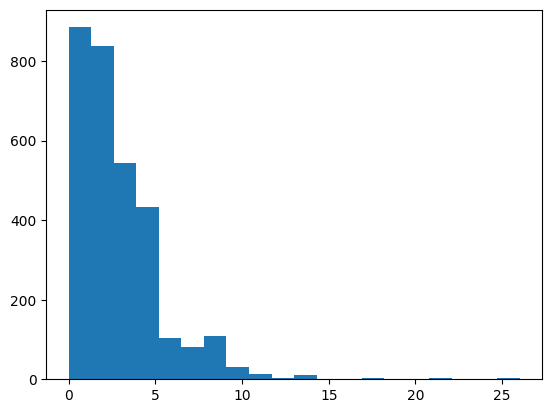

In [161]:
#taking a look at the building levels in the 100000 building sample
plt.hist(gdf['building:levels'].astype(float), bins=20)
plt.show()

In [78]:
#if one wants to store a gdf, this is how you do it
#gdf.to_file('datafram.shp')

/tmp/ipykernel_2616/2662106380.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file('datafram.shp')


In [84]:
#learning new stuff about the projection
gdf.crs

<Derived Projected CRS: +proj=utm +zone=33 +ellps=WGS84 +datum=WGS84 +unit ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: UTM zone 33N
- method: Transverse Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [85]:
#testing filtering out the Stockholm region using the cx-function
gdf_s = gdf.cx[636513:711110, 6618371:6565834]

In [119]:
i = 200000
while i < len(buildinghandler.buildings):
    dfx = pd.DataFrame(buildinghandler.buildings[(i-200000):min([i, len(buildinghandler.buildings)-1])])
    gdfx = geopandas.GeoDataFrame(dfx, geometry='geometry')
    gdfx = gdfx.set_crs("EPSG:4326")
    gdfx = ox.project_gdf(gdfx)
    gdfx = gdfx.dropna(subset=['building:levels'])
    gdfx = gdfx[['w_id', 'geometry', 'building:levels']]
    if i < 200001:
        meta = gdfx
    else:
        meta = pd.concat([meta, gdfx])
    print(meta.shape)
    i += 200000

(3891, 3)
(5168, 3)
(6180, 3)
(6930, 3)
(7864, 3)
(8890, 3)
(11317, 3)
(11989, 3)
(12931, 3)
(13711, 3)


In [134]:
#meta['floorarea'] = meta.area * meta['building:levels'].astype(float)
meta = meta[meta['building:levels'].str.contains('[A-Za-z]') == False]

In [143]:
meta = meta[meta['building:levels'].str.contains('[;-]') == False]
meta.shape

(13705, 3)

In [144]:
meta['floorarea'] = meta.area * meta['building:levels'].astype(float)

In [152]:
meta['ratio'] = meta['floorarea'].astype(float) / meta.area

In [153]:
meta['ratio'].mean()

2.0668004377964246

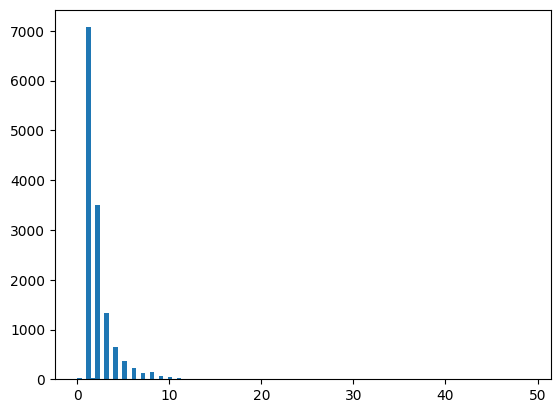

In [160]:
plt.hist(meta['ratio'], bins=100)
plt.show()

In [156]:
meta['ratio'].max()

48.99999999999999

In [157]:
meta[meta['ratio'] > 20].shape

(6, 5)

In [158]:
meta[meta['ratio'] > 20]

,w_id,geometry,building:levels,floorarea,ratio
2535,59423490,"MULTIPOLYGON (((373039.384 6163194.017, 373046...",26,27327.078762,26.0
2537,59569900,"MULTIPOLYGON (((374040.747 6162961.813, 374081...",22,25848.665522,22.0
4280,66069654,"MULTIPOLYGON (((674110.777 6582951.007, 674122...",21,10743.761927,21.0
84543,190297506,"MULTIPOLYGON (((587410.644 6609141.111, 587431...",25,103439.323883,25.0
103503,2128066182,"MULTIPOLYGON (((609698.812 6651238.056, 609707...",49,2398.426236,49.0
169823,2210736504,"MULTIPOLYGON (((320791.408 6400026.902, 320793...",37,36491.524549,37.0
